# Classification analysis of the dataset with 5 columns (no missing values)


In [1]:
import numpy as np
import pandas as pd
import statistics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, recall_score, average_precision_score
from matplotlib.colors import ListedColormap
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

### reading the dataset and applying one-hot encoding 

In [2]:
df = pd.read_csv('dataset.txt', encoding='ISO-8859-1', delimiter='\t', dtype=str)
X = df.iloc[:, 2:7]
new_column = pd.get_dummies(pd.DataFrame(X)).columns
encoder = OneHotEncoder()
X = encoder.fit_transform(np.array(X))
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df.iloc[:, 0])
for i in range(len(y)):
    if y[i] == 1: y[i] = 0
    else: y[i] = 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=40)
lr_clf = LogisticRegression(solver='lbfgs')
rf_clf = RandomForestClassifier(n_estimators=100)
svm_clf = SVC(gamma='auto', probability=True)

In [3]:
def plotScores(my_list, title_10fold, title_5fold, filename):
    labels = ['LR', 'RF', 'SVM']
    titles = [title_10fold, title_5fold]
    plt.figure(figsize=(12, 8))
    index = np.arange(len(labels))
    colors = ('green', 'blue', 'orange', 'red')
    for i in range(1, 3):
        ax1 = plt.subplot(2, 2, i)
        plotter = ax1.bar(index, my_list[i-1], color=colors)
        ax1.title.set_text(titles[i-1])
        ax1.legend((plotter[0], plotter[1], plotter[2]), my_list[i-1], loc=4)
        ax1.set_ylim((0, 100))
        ax1.set_xlabel('Classifiers', fontsize=10)
        ax1.set_ylabel('Classifiers\'s Scores', fontsize=10)
        ax1.set_xticks(index)
        ax1.set_xticklabels(labels, fontsize=11, rotation=30)
    plt.subplots_adjust(hspace=0.7, wspace=0.4)
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

### calculating accuracy scores after applying StratifiedKFold

In [4]:
def getAccuracyScore(clf, X, y, n):
    skf = StratifiedKFold(n_splits=n, random_state=40)
    scores = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
        clf.fit(X_train, y_train)
        scores.append(clf.score(X_test, y_test))
    return round(statistics.mean(scores)*100, 2)

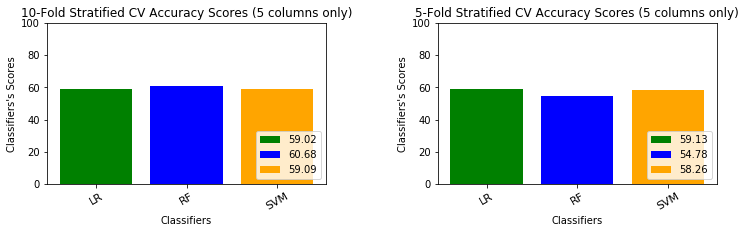

In [5]:
acc10fold_title = '10-Fold Stratified CV Accuracy Scores (5 columns only)'
acc5fold_title = '5-Fold Stratified CV Accuracy Scores (5 columns only)'
tenfold_scores = [getAccuracyScore(lr_clf, X, y, 10), getAccuracyScore(rf_clf, X, y, 10), getAccuracyScore(svm_clf, X, y, 10)]
fivefold_scores = [getAccuracyScore(lr_clf, X, y, 5), getAccuracyScore(rf_clf, X, y, 5), getAccuracyScore(svm_clf, X, y, 5)]
plotScores([tenfold_scores, fivefold_scores], acc10fold_title, acc5fold_title, 'accuracy scores (5 columns only)')

### calculating auc scores and plotting ROC

In [6]:
def getROCScores(classifier, X_train, y_train, X_test, y_test, label):
    classifier.fit(X_train, y_train)
    probs = classifier.predict_proba(X_test)
    probs = probs[:, 1]
    auc = roc_auc_score(y_test, probs)
    fpr, tpr, thresholds = roc_curve(y_test, probs)
    return auc, fpr, tpr, thresholds, label

In [7]:
def plotROC(scores, title, filename):
    plt.plot(scores[0][1], scores[0][2], marker='.', color='black', label='{}: {}'.format(scores[0][4], round(scores[0][0],2)))
    plt.plot(scores[1][1], scores[1][2], marker='.', color='red', label='{}: {}'.format(scores[1][4], round(scores[1][0],2)))
    plt.plot(scores[2][1], scores[2][2], marker='.', color='blue', label='{}: {}'.format(scores[2][4], round(scores[2][0],2)))
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive')
    plt.ylabel('True Positive')
    plt.title(title)
    plt.legend()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

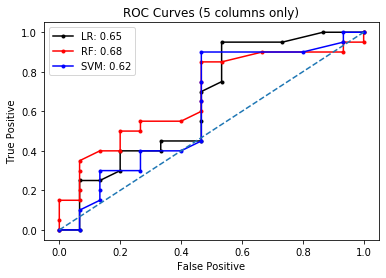

In [8]:
roc_lr = getROCScores(lr_clf, X_train, y_train, X_test, y_test, 'LR')
roc_rf = getROCScores(rf_clf, X_train, y_train, X_test, y_test, 'RF')
roc_svm = getROCScores(svm_clf, X_train, y_train, X_test, y_test, 'SVM')
plotROC([roc_lr, roc_rf, roc_svm], 'ROC Curves (5 columns only)', 'roc_curves (5 columns only)')

### calculating f1-scores

In [9]:
def find_f1(clf, X, y, n):
    scores = cross_val_score(clf, X, y, cv=n, scoring='f1')
    return round(scores.mean()*100,2)

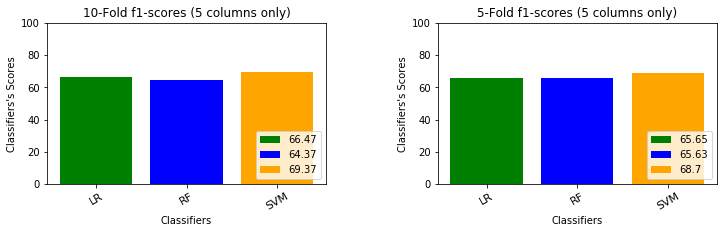

In [10]:
f1_10fold_title = '10-Fold f1-scores (5 columns only)'
f1_5fold_title = '5-Fold f1-scores (5 columns only)'
tenfold_f1scores = [find_f1(lr_clf, X, y, 10), find_f1(rf_clf, X, y, 10), find_f1(svm_clf, X, y, 10)]
fivefold_f1scores = [find_f1(lr_clf, X, y, 5), find_f1(rf_clf, X, y, 5), find_f1(svm_clf, X, y, 5)]
plotScores([tenfold_f1scores, fivefold_f1scores], f1_10fold_title, f1_5fold_title, 'f1 scores (5 columns only)')

### applying feature importance using Random Forest

In [11]:
def feature_importance(X_train, y_train, title, filename, labels):
    feat_labels = labels
    rf_clf.fit(X_train, y_train)
    importances = rf_clf.feature_importances_
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(15,5))
    plt.title(title)
    plt.bar(range(X_train.shape[1]), importances[indices], color='lightgreen', align='center')
    plt.xticks(range(X_train.shape[1]), feat_labels[indices], rotation=90)
    plt.xlim([-1, X_train.shape[1]])
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()

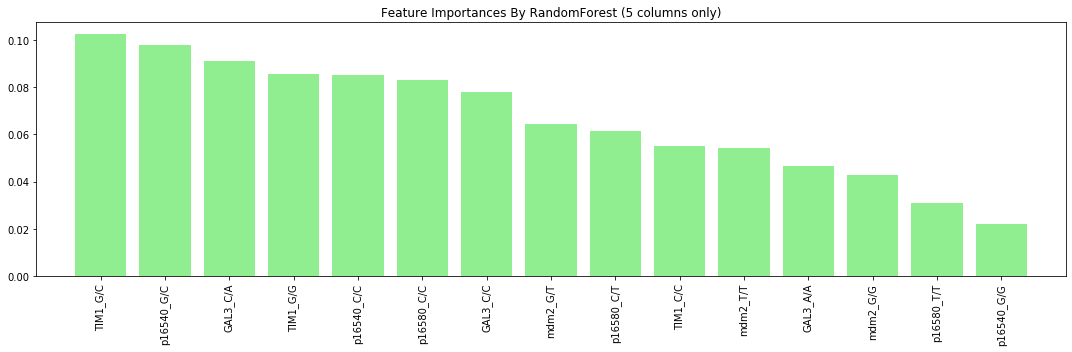

In [12]:
features_title = 'Feature Importances By RandomForest (5 columns only)'
feature_importance(X_train, y_train, features_title, 'feature_importance (5 columns only)', new_column)

### plotting decision regions

In [13]:
def plot_decision_regions(X, y, classifier, resolution=0.02):
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    x1_min, x1_max = -0.1,1.1
    x2_min, x2_max = -0.1,1.1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)

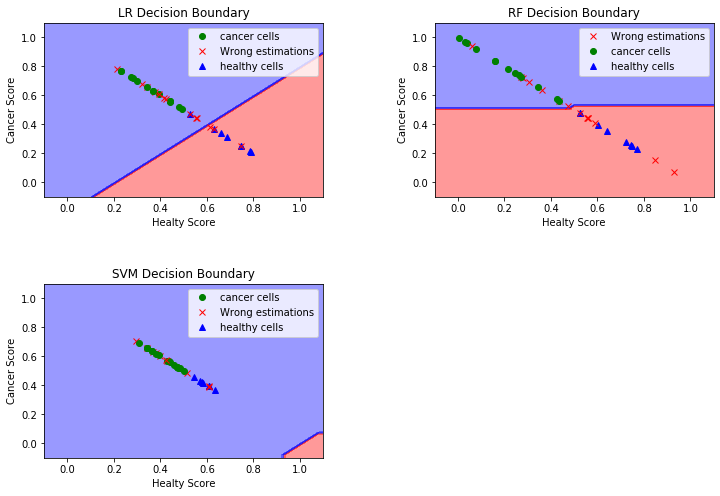

In [16]:
def plotEstimations(X_train, y_train, clfs):
    plt.figure(figsize=(12, 8))
    classifiers = clfs
    titles = ['LR Decision Boundary', 'RF Decision Boundary', 'SVM Decision Boundary']
    for j in range(1, 4):
        clf = classifiers[j-1]
        ax1 = plt.subplot(2, 2, j)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        errors = np.where(y_pred == y_test, True, False)
        prob = clf.predict_proba(X_test)
        for i in range(len(y_pred)):
            if not errors[i]: ax1.plot(prob[i,0],prob[i,1],'x',color='red',label='Wrong estimations')
            else:
                if y_test[i]: ax1.plot(prob[i,0],prob[i,1],'o',color='green',label='cancer cells')
                else: ax1.plot(prob[i,0],prob[i,1],'^',color='blue',label='healthy cells')
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax1.legend(by_label.values(), by_label.keys())
        ax1.set_xlabel('Healty Score')
        ax1.set_ylabel('Cancer Score')
        ax1.title.set_text(titles[j-1])
        clf.fit(prob,y_pred)
        plot_decision_regions(prob,y_pred,clf)
    plt.subplots_adjust(hspace=0.5, wspace=0.4)
    plt.savefig('decision_boundaries (5 columns only)', dpi=300, bbox_inches='tight')
    plt.show()

plotEstimations(X_train, y_train, [lr_clf, rf_clf, svm_clf])